***ver1.06***

特徴量選択を行い､ハイパーパラメータ調整

In [105]:
!python -V

Python 3.7.12


In [106]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [107]:
!pip install ccxt 
!pip install "git+https://github.com/richmanbtc/crypto_data_fetcher.git@v0.0.17#egg=crypto_data_fetcher"

  Cloning https://github.com/richmanbtc/crypto_data_fetcher.git (to revision v0.0.17) to /tmp/pip-install-idecm5r3/crypto-data-fetcher_869e15bbba4e42308e86fc00b58b276d
  Running command git clone -q https://github.com/richmanbtc/crypto_data_fetcher.git /tmp/pip-install-idecm5r3/crypto-data-fetcher_869e15bbba4e42308e86fc00b58b276d


In [108]:
!curl -L http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz -O && tar xzvf ta-lib-0.4.0-src.tar.gz
!cd ta-lib && ./configure --prefix=/usr && make && make install && cd - && pip install ta-lib

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   380  100   380    0     0   1176      0 --:--:-- --:--:-- --:--:--  1176
100   365  100   365    0     0    564      0 --:--:-- --:--:-- --:--:--  3288
100 1299k  100 1299k    0     0  1392k      0 --:--:-- --:--:-- --:--:-- 1392k
ta-lib/
ta-lib/config.sub
ta-lib/aclocal.m4
ta-lib/CHANGELOG.TXT
ta-lib/include/
ta-lib/include/ta_abstract.h
ta-lib/include/ta_func.h
ta-lib/include/ta_common.h
ta-lib/include/ta_config.h.in
ta-lib/include/Makefile.am
ta-lib/include/ta_libc.h
ta-lib/include/ta_defs.h
ta-lib/missing
ta-lib/ta-lib.spec.in
ta-lib/config.guess
ta-lib/Makefile.in
ta-lib/ta-lib.dpkg.in
ta-lib/Makefile.am
ta-lib/autogen.sh
ta-lib/install-sh
ta-lib/configure
ta-lib/depcomp
ta-lib/HISTORY.TXT
ta-lib/configure.in
ta-lib/autom4te.cache/
ta-lib/autom4te.cache/output.0
ta-lib/autom4te.cache/requests
ta-lib/autom4te.cache/outpu

In [109]:
!pip list

Package                       Version
----------------------------- --------------
absl-py                       0.12.0
aiodns                        3.0.0
aiohttp                       3.8.1
aiosignal                     1.2.0
alabaster                     0.7.12
albumentations                0.1.12
alembic                       1.7.5
altair                        4.1.0
appdirs                       1.4.4
argcomplete                   1.12.3
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
arviz                         0.11.4
astor                         0.8.1
astropy                       4.3.1
astunparse                    1.6.3
async-timeout                 4.0.2
asynctest                     0.13.0
atari-py                      0.2.9
atomicwrites                  1.4.0
attrs                         21.2.0
audioread                     2.1.9
autograd                      1.3
autopage                      0.4.0
Babel                         2.9.1
backcall  

**Libraryのインポート**

In [110]:
pip check

nbclient 0.5.9 has requirement jupyter-client>=6.1.5, but you have jupyter-client 5.3.5.
datascience 0.10.6 has requirement folium==0.2.1, but you have folium 0.8.3.
albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9.


In [111]:
!pip install -U lightgbm

In [112]:
!pip install optuna

In [113]:
from datetime import datetime
import calendar
from pprint import pprint
import pytz

import ccxt
from crypto_data_fetcher.gmo import GmoFetcher
import joblib
import lightgbm as lgb
import matplotlib.pyplot as plt
import numba
import numpy as np
import pandas as pd
from scipy.stats import ttest_1samp
import scipy.stats
import seaborn as sns
import talib
import optuna
import lightgbm as lgb_o

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import BaggingRegressor
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import RidgeCV, LinearRegression
from sklearn.model_selection import cross_val_score, KFold, TimeSeriesSplit
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import r2_score 

sns.set()

In [114]:
import warnings
warnings.filterwarnings('ignore')

***データを用意***  
GMOからOHLCVを取得   

15分足を利用

こちらのコードは20~30分ほど時間がかかります｡

データのダウンロードは一度で良いので､まとめてコメントアウトします｡

In [115]:
"""
memory = joblib.Memory('/tmp/gmo_fetcher_cache', verbose=0)
fetcher = GmoFetcher(memory=memory)

# GMOコインのBTC/JPYレバレッジ取引 ( https://api.coin.z.com/data/trades/BTC_JPY/ )を取得
# 初回ダウンロードは時間がかかる

#ダウンロードは1度で良いので､ランタイム再起動時に再度データを取得しないようにコメントアウト

df = fetcher.fetch_ohlcv(
    market='BTC_JPY', # 市場のシンボルを指定
    interval_sec=15 * 60, # 足の間隔を秒単位で指定。この場合は15分足
)

# 実験に使うデータ期間を限定する
#df = df[df.index < pd.to_datetime('2021-04-01 00:00:00Z')]

display(df)
df.to_pickle('/content/drive/My Drive/Colab Notebooks/deliverables/df_ohlcv.pkl')
"""

"\nmemory = joblib.Memory('/tmp/gmo_fetcher_cache', verbose=0)\nfetcher = GmoFetcher(memory=memory)\n\n# GMOコインのBTC/JPYレバレッジ取引 ( https://api.coin.z.com/data/trades/BTC_JPY/ )を取得\n# 初回ダウンロードは時間がかかる\n\n#ダウンロードは1度で良いので､ランタイム再起動時に再度データを取得しないようにコメントアウト\n\ndf = fetcher.fetch_ohlcv(\n    market='BTC_JPY', # 市場のシンボルを指定\n    interval_sec=15 * 60, # 足の間隔を秒単位で指定。この場合は15分足\n)\n\n# 実験に使うデータ期間を限定する\n#df = df[df.index < pd.to_datetime('2021-04-01 00:00:00Z')]\n\ndisplay(df)\ndf.to_pickle('/content/drive/My Drive/Colab Notebooks/deliverables/df_ohlcv.pkl')\n"

***maker手数料カラムを追加***  

bitgetのmaker手数料は0.04%
カラムに代入する際は､%表記ではなく､割合(少数)表記にして記述する｡ 

GMOさんのメイカー手数料は､現在は0となっている｡

過去にはマイナス手数料であったこともあるが､モデルの学習自体には関係ないため､一旦0で統一｡

In [116]:
df = pd.read_pickle('/content/drive/My Drive/Colab Notebooks/deliverables/df_ohlcv.pkl')
df["fee"] = 0.0#割合表記!!!!

df.to_pickle('/content/drive/My Drive/Colab Notebooks/deliverables/df_ohlcv_with_fee.pkl')
df

,op,hi,lo,cl,volume,fee
timestamp,,,,,,
2018-09-05 08:00:00+00:00,818724.0,818724.0,818724.0,818724.0,0.01,0.0
2018-09-05 08:15:00+00:00,821250.0,821250.0,821250.0,821250.0,0.01,0.0
2018-09-05 08:45:00+00:00,819260.0,819765.0,819260.0,819765.0,0.03,0.0
2018-09-05 09:00:00+00:00,820000.0,821388.0,819500.0,819546.0,1.22,0.0
2018-09-05 09:15:00+00:00,820441.0,821530.0,819646.0,820244.0,14.77,0.0
...,...,...,...,...,...,...
2021-12-13 19:45:00+00:00,5229128.0,5323800.0,5221657.0,5308370.0,137.49,0.0
2021-12-13 20:00:00+00:00,5308735.0,5336300.0,5292038.0,5330568.0,79.16,0.0
2021-12-13 20:15:00+00:00,5328614.0,5331890.0,5282118.0,5304779.0,66.96,0.0


***特徴量エンジニアリング*** 

テクニカル指標計算ライブラリのTA-Libを利用して特徴量を作成していく。

In [117]:
def calc_features(df):
    open = df['op']
    high = df['hi']
    low = df['lo']
    close = df['cl']
    volume = df['volume']

    orig_columns = df.columns
    
    hilo = (df['hi'] + df['lo']) / 2
    df['BBANDS_upperband'], df['BBANDS_middleband'], df['BBANDS_lowerband'] = talib.BBANDS(close, timeperiod=15, nbdevup=2, nbdevdn=2, matype=0)
    df['BBANDS_middleband'] -= hilo
    df['BBANDS_lowerband'] -= hilo
    df['DEMA'] = talib.DEMA(close, timeperiod=30) - hilo
    df['EMA'] = talib.EMA(close, timeperiod=30) - hilo
    df['HT_TRENDLINE'] = talib.HT_TRENDLINE(close) - hilo
    df['KAMA'] = talib.KAMA(close, timeperiod=30) - hilo
    df['MA'] = talib.MA(close, timeperiod=30, matype=0) - hilo
    df['MIDPOINT'] = talib.MIDPOINT(close, timeperiod=14) - hilo
    df['SMA'] = talib.SMA(close, timeperiod=30) - hilo
    df['T3'] = talib.T3(close, timeperiod=5, vfactor=0) - hilo
    df['TEMA'] = talib.TEMA(close, timeperiod=30) - hilo
    df['TRIMA'] = talib.TRIMA(close, timeperiod=30) - hilo
    df['WMA'] = talib.WMA(close, timeperiod=30) - hilo
    df['ADX'] = talib.ADX(high, low, close, timeperiod=14)
    df['ADXR'] = talib.ADXR(high, low, close, timeperiod=14)
    df['APO'] = talib.APO(close, fastperiod=12, slowperiod=26, matype=0)
    df['AROON_aroondown'], df['AROON_aroonup'] = talib.AROON(high, low, timeperiod=14)
    df['AROONOSC'] = talib.AROONOSC(high, low, timeperiod=14)
    df['BOP'] = talib.BOP(open, high, low, close)
    df['CCI'] = talib.CCI(high, low, close, timeperiod=14)
    df['DX'] = talib.DX(high, low, close, timeperiod=14)
    
    df['MACD_macd'], df['MACD_macdsignal'], df['MACD_macdhist'] = talib.MACD(close, fastperiod=12, slowperiod=26, signalperiod=9)
    # skip MACDEXT MACDFIX たぶん同じなので
    df['MFI'] = talib.MFI(high, low, close, volume, timeperiod=14)
    df['MINUS_DI'] = talib.MINUS_DI(high, low, close, timeperiod=14)
    df['MINUS_DM'] = talib.MINUS_DM(high, low, timeperiod=14)
    df['MOM'] = talib.MOM(close, timeperiod=10)
    df['PLUS_DI'] = talib.PLUS_DI(high, low, close, timeperiod=14)
    df['PLUS_DM'] = talib.PLUS_DM(high, low, timeperiod=14)
    df['RSI'] = talib.RSI(close, timeperiod=14)
    df['STOCH_slowk'], df['STOCH_slowd'] = talib.STOCH(high, low, close, fastk_period=5, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
    df['STOCHF_fastk'], df['STOCHF_fastd'] = talib.STOCHF(high, low, close, fastk_period=5, fastd_period=3, fastd_matype=0)
    df['STOCHRSI_fastk'], df['STOCHRSI_fastd'] = talib.STOCHRSI(close, timeperiod=14, fastk_period=5, fastd_period=3, fastd_matype=0)
    df['TRIX'] = talib.TRIX(close, timeperiod=30)
    df['ULTOSC'] = talib.ULTOSC(high, low, close, timeperiod1=7, timeperiod2=14, timeperiod3=28)
    df['WILLR'] = talib.WILLR(high, low, close, timeperiod=14)
    df['AD'] = talib.AD(high, low, close, volume)
    df['ADOSC'] = talib.ADOSC(high, low, close, volume, fastperiod=3, slowperiod=10)
    df['OBV'] = talib.OBV(close, volume)
    df['ATR'] = talib.ATR(high, low, close, timeperiod=14)
    df['NATR'] = talib.NATR(high, low, close, timeperiod=14)
    df['TRANGE'] = talib.TRANGE(high, low, close)
    df['HT_DCPERIOD'] = talib.HT_DCPERIOD(close)
    df['HT_DCPHASE'] = talib.HT_DCPHASE(close)
    df['HT_PHASOR_inphase'], df['HT_PHASOR_quadrature'] = talib.HT_PHASOR(close)
    df['HT_SINE_sine'], df['HT_SINE_leadsine'] = talib.HT_SINE(close)
    df['HT_TRENDMODE'] = talib.HT_TRENDMODE(close)
    df['BETA'] = talib.BETA(high, low, timeperiod=5)
    df['CORREL'] = talib.CORREL(high, low, timeperiod=30)
    df['LINEARREG'] = talib.LINEARREG(close, timeperiod=14) - close
    df['LINEARREG_ANGLE'] = talib.LINEARREG_ANGLE(close, timeperiod=14)
    df['LINEARREG_INTERCEPT'] = talib.LINEARREG_INTERCEPT(close, timeperiod=14) - close
    df['LINEARREG_SLOPE'] = talib.LINEARREG_SLOPE(close, timeperiod=14)
    df['STDDEV'] = talib.STDDEV(close, timeperiod=5, nbdev=1)
    df["CMO"] = talib.CMO(close, timeperiod=14)
    df["PLUS_DI"] = talib.PLUS_DI(high, low, close, timeperiod=14)
    df["MINUS_DI"] = talib.PLUS_DI(high, low, close, timeperiod=14)
    df["ROC"] = talib.ROC(close, timeperiod=14)
    df["CDLLADDERBOTTOM"] = talib.CDLLADDERBOTTOM(open, high, low, close)
    df["PPO"] = talib.PPO(close, fastperiod=12, slowperiod=26, matype=0)
    df["AVGPRICE"] = talib.AVGPRICE(open, high, low, close)
    df["HT_TRENDLINE"] = talib.HT_TRENDLINE(close)
    df["SAREXT"] = talib.SAREXT(high, low)
    df["APO"] = talib.APO(close)

    return df

df = pd.read_pickle('/content/drive/My Drive/Colab Notebooks/deliverables/df_ohlcv_with_fee.pkl')

df = df.dropna()

df = calc_features(df)

df.to_pickle('/content/drive/My Drive/Colab Notebooks/deliverables/df_features.pkl')

df

,op,hi,lo,cl,volume,fee,BBANDS_upperband,BBANDS_middleband,BBANDS_lowerband,DEMA,EMA,HT_TRENDLINE,KAMA,MA,MIDPOINT,SMA,T3,TEMA,TRIMA,WMA,ADX,ADXR,APO,AROON_aroondown,AROON_aroonup,AROONOSC,BOP,CCI,DX,MACD_macd,MACD_macdsignal,MACD_macdhist,MFI,MINUS_DI,MINUS_DM,MOM,PLUS_DI,PLUS_DM,RSI,STOCH_slowk,STOCH_slowd,STOCHF_fastk,STOCHF_fastd,STOCHRSI_fastk,STOCHRSI_fastd,TRIX,ULTOSC,WILLR,AD,ADOSC,OBV,ATR,NATR,TRANGE,HT_DCPERIOD,HT_DCPHASE,HT_PHASOR_inphase,HT_PHASOR_quadrature,HT_SINE_sine,HT_SINE_leadsine,HT_TRENDMODE,BETA,CORREL,LINEARREG,LINEARREG_ANGLE,LINEARREG_INTERCEPT,LINEARREG_SLOPE,STDDEV,CMO,ROC,CDLLADDERBOTTOM,PPO,AVGPRICE,SAREXT
timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-09-05 08:00:00+00:00,818724.0,818724.0,818724.0,818724.0,0.01,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,0.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,818724.00,NaN
2018-09-05 08:15:00+00:00,821250.0,821250.0,821250.0,821250.0,0.01,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,0.02,NaN,NaN,2526.0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,821250.00,8.187240e+05
2018-09-05 08:45:00+00:00,819260.0,819765.0,819260.0,819765.0,0.03,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.030000,NaN,-0.01,NaN,NaN,1990.0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,819512.50,8.187745e+05
2018-09-05 09:00:00+00:00,820000.0,821388.0,819500.0,819546.0,1.22,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.240466,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.130551,NaN,-1.23,NaN,NaN,1888.0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,820108.50,8.188240e+05
2018-09-05 09:15:00+00:00,820441.0,821530.0,819646.0,820244.0,14.77,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.104565,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-6.524266,NaN,13.54,NaN,NaN,1984.0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,832.728623,NaN,NaN,0,NaN,820465.25,8.189266e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-13 19:45:00+00:00,5229128.0,5323800.0,5221657.0,5308370.0,137.49,0.0,5.449229e+06,80084.366667,-16331.403537,46899.197668,123605.925882,5.433664e+06,79759.319473,131710.966667,47950.0,131710.966667,81390.383153,25535.207250,123760.350000,95907.218280,50.037635,56.333154,-32494.314103,92.857143,21.428571,-71.428571,0.775795,-116.184761,45.152954,-46295.729161,-40421.709340,-5874.019821,40.580623,13.688627,254601.314280,-79430.0,13.688627,96202.864687,38.597607,31.121454,23.069786,60.184493,31.121454,88.715347,29.571782,-0.068991,47.707016,-51.679597,269740.908278,-12.959763,12209.34,50199.578801,0.945668,102143.0,33.958571,20.956972,-11953.602459,-104553.591757,0.357667,0.913240,1,0.831150,0.963103,-1579.685714,-89.992028,91850.685714,-7186.951648,55403.539935,-22.804786,-0.650295,0,-0.603182,5270738.75,-5.423979e+06
2021-12-13 20:00:00+00:00,5308735.0,5336300.0,5292038.0,5330568.0,79.16,0.0,5.448930e+06,37807.333333,-59146.691289,2195.270034,77922.430664,5.420780e+06,37016.369207,83509.500000,6509.5,83509.500000,30243.031857,-16874.028747,75814.241667,49700.817204,49.305575,56.349991,-31981.493590,85.7142

***カテゴリ変数のカラムを保存しておく｡***

In [118]:
category_col = df.nunique()
category_col = category_col[category_col==2]
category_col.index

Index(['HT_TRENDMODE', 'CDLLADDERBOTTOM'], dtype='object')

***目的変数の計算***


約定確率を可視化。時期によって約定確率が大きく変わると良くない。


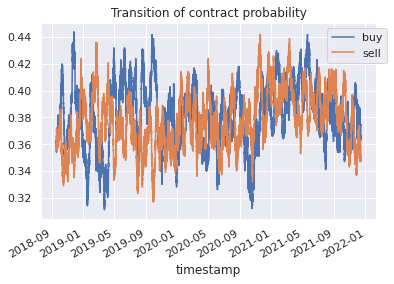

エグジットまでの時間分布を可視化。長すぎるとロングしているだけとかショートしているだけになるので良くない。


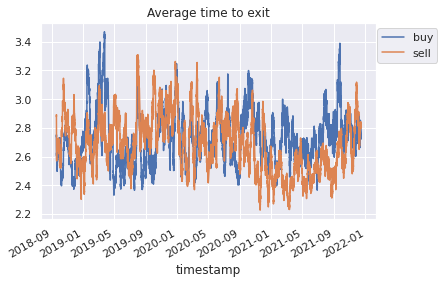

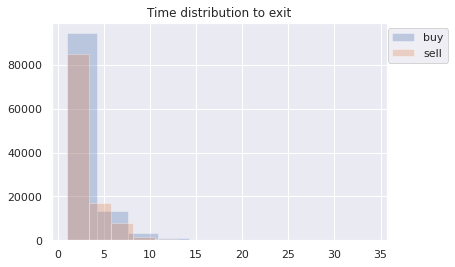

毎時刻、この執行方法でトレードした場合の累積リターン


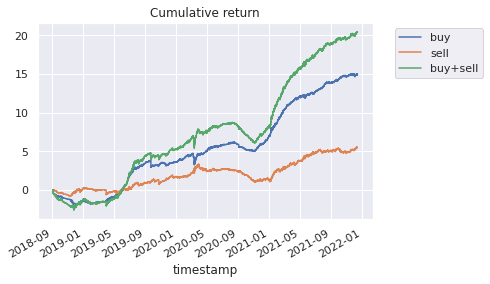

In [119]:
@numba.njit
def calc_force_entry_price(entry_price=None, lo=None, pips=None):
    """
    return -> 
    """
    y = entry_price.copy()
    y[:] = np.nan
    force_entry_time = entry_price.copy()
    force_entry_time[:] = np.nan
    for i in range(entry_price.size):
        for j in range(i + 1, entry_price.size):
            if round(lo[j] / pips) < round(entry_price[j - 1] / pips):
                y[i] = entry_price[j - 1]
                force_entry_time[i] = j - i
                break
    return y, force_entry_time

df = pd.read_pickle('/content/drive/My Drive/Colab Notebooks/deliverables/df_features.pkl')

# 呼び値 (取引所、取引ペアごとに異なるので、適切に設定してください)
pips = 0.1

# ATRで指値距離を計算します
limit_price_dist = df['ATR'] * 0.5
limit_price_dist = np.maximum(1, (limit_price_dist / pips).round().fillna(1)) * pips

# 終値から両側にlimit_price_distだけ離れたところに、買い指値と売り指値を出します
df['buy_price'] = df['cl'] - limit_price_dist
df['sell_price'] = df['cl'] + limit_price_dist

# Force Entry Priceの計算
df['buy_fep'], df['buy_fet'] = calc_force_entry_price(
    entry_price=df['buy_price'].values,
    lo=df['lo'].values,
    pips=pips,
)

# calc_force_entry_priceは入力と出力をマイナスにすれば売りに使えます
df['sell_fep'], df['sell_fet'] = calc_force_entry_price(
    entry_price=-df['sell_price'].values,
    lo=-df['hi'].values, # 売りのときは高値
    pips=pips,
)
df['sell_fep'] *= -1

horizon = 1 # エントリーしてからエグジットを始めるまでの待ち時間 (1以上である必要がある)
fee = df['fee'] # maker手数料

# 指値が約定したかどうか (0, 1)
df['buy_executed'] = ((df['buy_price'] / pips).round() > (df['lo'].shift(-1) / pips).round()).astype('float64')
df['sell_executed'] = ((df['sell_price'] / pips).round() < (df['hi'].shift(-1) / pips).round()).astype('float64')

# yを計算
df['y_buy'] = np.where(
    df['buy_executed'],
    df['sell_fep'].shift(-horizon) / df['buy_price'] - 1 - 2 * fee,
    0
)
df['y_sell'] = np.where(
    df['sell_executed'],
    -(df['buy_fep'].shift(-horizon) / df['sell_price'] - 1) - 2 * fee,
    0
)

# バックテストで利用する取引コストを計算
df['buy_cost'] = np.where(
    df['buy_executed'],
    df['buy_price'] / df['cl'] - 1 + fee,
    0
)
df['sell_cost'] = np.where(
    df['sell_executed'],
    -(df['sell_price'] / df['cl'] - 1) + fee,
    0
)

print('約定確率を可視化。時期によって約定確率が大きく変わると良くない。')
df['buy_executed'].rolling(1000).mean().plot(label='buy')
df['sell_executed'].rolling(1000).mean().plot(label='sell')
plt.title('Transition of contract probability')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

print('エグジットまでの時間分布を可視化。長すぎるとロングしているだけとかショートしているだけになるので良くない。')
df['buy_fet'].rolling(1000).mean().plot(label='buy')
df['sell_fet'].rolling(1000).mean().plot(label='sell')
plt.title('Average time to exit')
plt.legend(bbox_to_anchor=(1.2, 1))
plt.show()

df['buy_fet'].hist(alpha=0.3, label='buy')
df['sell_fet'].hist(alpha=0.3, label='sell')
plt.title('Time distribution to exit')
plt.legend(bbox_to_anchor=(1.2, 1))
plt.show()

print('毎時刻、この執行方法でトレードした場合の累積リターン')
df['y_buy'].cumsum().plot(label='buy')
df['y_sell'].cumsum().plot(label='sell')
(df['y_buy'] + df['y_sell']).cumsum().plot(label='buy+sell')
plt.title('Cumulative return')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

df.to_pickle('/content/drive/My Drive/Colab Notebooks/deliverables/df_y.pkl')

In [120]:
#モデルの学習とOOS予測値計算
df = pd.read_pickle('/content/drive/My Drive/Colab Notebooks/deliverables/df_y.pkl')
df = df.dropna()

#標準化が必要のないカラムについて､別で保存しておく
not_stz_col = list(category_col.index) + ["fee", "y_buy", "y_sell"]
not_stz = df[not_stz_col]
df = df.drop(not_stz_col, axis=1)

columns = df.columns.values
index = df.index

#DFを標準化
df = scipy.stats.zscore(df, ddof=1)
df = pd.DataFrame(df)
df.columns = columns
df.index = index
df = df.join(not_stz)

#カラムを特徴量と目的変数のみにしておく
drop_col =  ['op', 'hi', 'lo', 'cl',  'buy_price','sell_price', 'buy_fep', 
              'buy_fet', 'sell_fep', 'sell_fet', 'buy_executed', 
              'sell_executed', 'buy_cost', 'sell_cost', 'fee']

df = df.drop(drop_col, axis=1)

df.to_pickle('/content/drive/My Drive/Colab Notebooks/deliverables/df_for_learn.pkl')

In [121]:
from re import VERBOSE
#lightgbmモデルを入れると特徴量重要度のDFを作成してくれる関数
def make_imp_df(model, Normalization=True):
    importance_df = pd.DataFrame({"feature":[], "importance":[]})
    cols = model.feature_name_
    f_importance = np.array(model.feature_importances_) # 特徴量重要度の算出
    importance_df = pd.concat((importance_df, 
                                pd.DataFrame({"feature": cols, "importance": f_importance})))

    if Normalization:
        importance_df["importance"] = (importance_df["importance"] / 
                                            np.sum(importance_df["importance"])) * 100 #正規化(%)

    return importance_df


# 特徴量重要度を棒グラフでプロットする関数 
def plot_feature_importance(df, title=None): 
    n_features = len(df)                              # 特徴量数(説明変数の個数) 
    df_plot = df.sort_values('importance')            # df_importanceをプロット用に特徴量重要度を昇順ソート 
    f_importance_plot = df_plot['importance'].values  # 特徴量重要度の取得 
    plt.figure(figsize=(6,15))
    plt.barh(range(n_features), f_importance_plot, align='center') 
    cols_plot = df_plot['feature'].values             # 特徴量の取得 
    plt.yticks(np.arange(n_features), cols_plot)      # x軸,y軸の値の設定
    plt.xlabel('Feature importance(%)')                  # x軸のタイトル
    plt.ylabel('Feature')                             # y軸のタイトル
    plt.title(title)
    plt.grid(True)
    plt.show()


#my_cross_val_predict()や､my_classification_learning()からのimportance_dfをgroupbyで処理する関数
def importance_groupby(importance_df, graph_title="feature importance", normalize=True):
    importance_df = importance_df.groupby("feature", as_index=False).mean().sort_values("importance", ascending=False)
    if normalize:
        importance_df["importance"] = (importance_df["importance"] / np.sum(importance_df["importance"])) * 100 #正規化(%)
    plot_feature_importance(importance_df, graph_title)
    
    return importance_df


# 評価
def calculate_scores(true, pred):
    """全ての評価指標を計算する

    Parameters
    ----------
    true (np.array)       : 実測値
    pred (np.array)       : 予測値

    Returns
    -------
    scores (pd.DataFrame) : 各評価指標を纏めた結果

    """
    mod = LinearRegression()

    plt.plot(true, true, color = 'red', label = 'x=y') # 直線y = x (真値と予測値が同じ場合は直線状に点がプロットされる)
    plt.scatter(true, pred) # 散布図のプロット
    plt.xlabel('true') # x軸ラベル
    plt.ylabel('pred') # y軸ラベル
    plt.title('true vs pred') # グラフタイトル

    df_true = pd.DataFrame(true)
    df_pred = pd.DataFrame(pred)

    mod.fit(df_true, df_pred)
    lin_reg = mod.predict(df_true)
    plt.plot(true, lin_reg, color = '#008000', linewidth=2)
    plt.show()

    scores = pd.DataFrame({'R2': r2_score(true, pred),
                             'MSE': mean_squared_error(true, pred),
                             'RMSE': np.sqrt(mean_squared_error(true, pred))},
                             index = ['scores'])
    return scores

def my_cross_val_predict(X, y, cv_index=None, x_test=None, y_test=None):
    
    #変数の用意
    y_pred = np.zeros(len(X))
    y_pred[:] = np.nan

    #テストデータが存在する時
    if x_test is not None:
        y_test_pred = np.zeros(len(x_test))
    else:
        y_test_pred = None

    #固定するパラメータ
    params = {'objective': 'regression',
               'metric': 'rmse',
               'extra_trees': True,
               'random_seed': 0,
             } 

    evaluate_score_list = []
    importance_df = pd.DataFrame({"feature":[], "importance":[]})

    for trn_idx, val_idx in cv_index:
        x_trn, x_val = X.iloc[trn_idx], X.iloc[val_idx]
        y_trn, y_val = y.iloc[trn_idx], y.iloc[val_idx]

        # 訓練データ
        lgb_train = lgb_o.Dataset(x_trn, y_trn)
        # 評価データ
        lgb_eval = lgb_o.Dataset(x_val, y_val, reference=lgb_train)
        
        #モデルの学習
        # モデルの学習
        model = lgb_o.train(params,
                         train_set=lgb_train,
                         valid_sets=lgb_eval,
                         early_stopping_rounds=100,
                         verbose_eval=-1,
                         )


        #Foldごとに重要度の格納
        cols = X.columns.values
        f_importance = np.array(model.feature_importance(importance_type='gain')) # 特徴量重要度の算出
        importance_df = pd.concat((importance_df, pd.DataFrame(
                                        {"feature": cols, "importance": f_importance})))

        y_pred[val_idx] = model.predict(x_val)

        if x_test is not None:
            y_test_pred += model.predict(x_test)
            print(y_test_pred)
    
    #テストデータでの評価
    if y_test_pred is not None:
        print(y_test_pred)
        y_test_pred = y_test_pred / len(cv_index)
        print(y_test_pred)

    ret = {"y_pred": y_pred, 
            "importance_df": importance_df,
            "y_test_pred": y_test_pred} 

    return ret


#学習データ全体で学習したものと､テストデータで検証を行っていく
def model_performance(y, y_pred, title=None):

    plt.plot(y, y, color = 'red', label = 'x=y') # 直線y = x (真値と予測値が同じ場合は直線状に点がプロットされる)
    plt.scatter(y, y_pred) # 散布図のプロット
    plt.xlabel('y') # x軸ラベル
    plt.ylabel('y_pred') # y軸ラベル
    if title is None:
        plt.title('y vs y_pred') # グラフタイトル
    else:
        plt.title(title)

    plt.show()

    #モデルの評価
    ms_error = mean_squared_error(y, y_pred)
    r2 = r2_score(y, y_pred)

    evaluations_df = pd.DataFrame(np.array([ms_error, r2]).reshape([1, 2]),
                                    columns=["mean squared error", "r2_score"])

    display(evaluations_df)

    return evaluations_df

***エントリーしたところだけで見たリターン予測(回帰)***

In [122]:
#カラムを表示
df = pd.read_pickle('/content/drive/My Drive/Colab Notebooks/deliverables/df_for_learn.pkl')

features = df.columns.values
features = features[(features!="y_buy") & (features!="y_sell")]
features

array(['volume', 'BBANDS_upperband', 'BBANDS_middleband',
       'BBANDS_lowerband', 'DEMA', 'EMA', 'HT_TRENDLINE', 'KAMA', 'MA',
       'MIDPOINT', 'SMA', 'T3', 'TEMA', 'TRIMA', 'WMA', 'ADX', 'ADXR',
       'APO', 'AROON_aroondown', 'AROON_aroonup', 'AROONOSC', 'BOP',
       'CCI', 'DX', 'MACD_macd', 'MACD_macdsignal', 'MACD_macdhist',
       'MFI', 'MINUS_DI', 'MINUS_DM', 'MOM', 'PLUS_DI', 'PLUS_DM', 'RSI',
       'STOCH_slowk', 'STOCH_slowd', 'STOCHF_fastk', 'STOCHF_fastd',
       'STOCHRSI_fastk', 'STOCHRSI_fastd', 'TRIX', 'ULTOSC', 'WILLR',
       'AD', 'ADOSC', 'OBV', 'ATR', 'NATR', 'TRANGE', 'HT_DCPERIOD',
       'HT_DCPHASE', 'HT_PHASOR_inphase', 'HT_PHASOR_quadrature',
       'HT_SINE_sine', 'HT_SINE_leadsine', 'BETA', 'CORREL', 'LINEARREG',
       'LINEARREG_ANGLE', 'LINEARREG_INTERCEPT', 'LINEARREG_SLOPE',
       'STDDEV', 'CMO', 'ROC', 'PPO', 'AVGPRICE', 'SAREXT',
       'HT_TRENDMODE', 'CDLLADDERBOTTOM'], dtype=object)

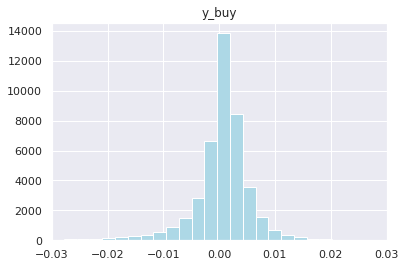

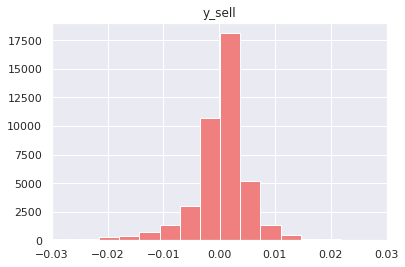

In [123]:
#損益が0の行を取り除いたDF(回帰用) 
df_reg_buy = df[df["y_buy"]!=0]
df_reg_sell = df[df["y_sell"]!=0]

#可視化
plt.hist(df_reg_buy["y_buy"], bins=100, color="lightblue", label="y_buy")
plt.xlim(-0.03, 0.03)
plt.title("y_buy")
plt.show()

plt.hist(df_reg_sell["y_sell"], bins=100, color="lightcoral", label="y_sell")
plt.xlim(-0.03, 0.03)
plt.title("y_sell")
plt.show()

#学習用と テスト用 に分割
#一応時系列として､過去から未来を予測する｡
test_size = 0.2
train_df, test_df = train_test_split(df, test_size=test_size, shuffle=False)

#エントリーしたところのみのDF作成(y_buy!=0  y_sell!=0)
train_df_buy = train_df[train_df["y_buy"]!=0]
train_df_sell = train_df[train_df["y_sell"]!=0]

# KFold法 インデックス番号(0,1,2,3,,,,)で出てくるので注意! ilocをつかう
cv_indicies_buy = list(KFold().split(train_df_buy))
cv_indicies_sell = list(KFold().split(train_df_sell))

In [124]:
#optunaのログ出力レベルを設定
optuna.logging.set_verbosity(-1)

print("prediction of y_buy")
#Light_GBMの結果から､特徴量重要度を降順にソートしてリスト化する｡
#重要度の低いものから省いて､特徴量選択を行う
buy_features = features

r_buy_reg = my_cross_val_predict(train_df_buy[buy_features], train_df_buy['y_buy'], cv_indicies_buy)

prediction of y_buy
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.039724 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16384
[LightGBM] [Info] Number of data points in the train set: 27440, number of used features: 68
[LightGBM] [Info] Start training from score 0.000487
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[11]	valid_0's rmse: 0.00561225
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022457 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16384
[LightGBM] [Info] Number of data points in the train set: 27440, number of used features: 68
[LightGBM] [Info] Start training from score 0.000283
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[17]	valid_0's rmse: 0.00762083
[Lig

In [125]:
print(print("prediction of y_sell"))
#Light_GBMの結果から､特徴量重要度を降順にソートしてリスト化する｡
#重要度の低いものから省いて､特徴量選択を行う
sell_features = features

r_sell_reg = my_cross_val_predict(train_df_sell[sell_features], train_df_sell['y_sell'], cv_indicies_sell)

prediction of y_sell
None
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019733 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16384
[LightGBM] [Info] Number of data points in the train set: 27106, number of used features: 68
[LightGBM] [Info] Start training from score 0.000131
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[2]	valid_0's rmse: 0.00524381
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044129 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16384
[LightGBM] [Info] Number of data points in the train set: 27106, number of used features: 68
[LightGBM] [Info] Start training from score 0.000083
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[6]	valid_0's rmse: 0.00739131


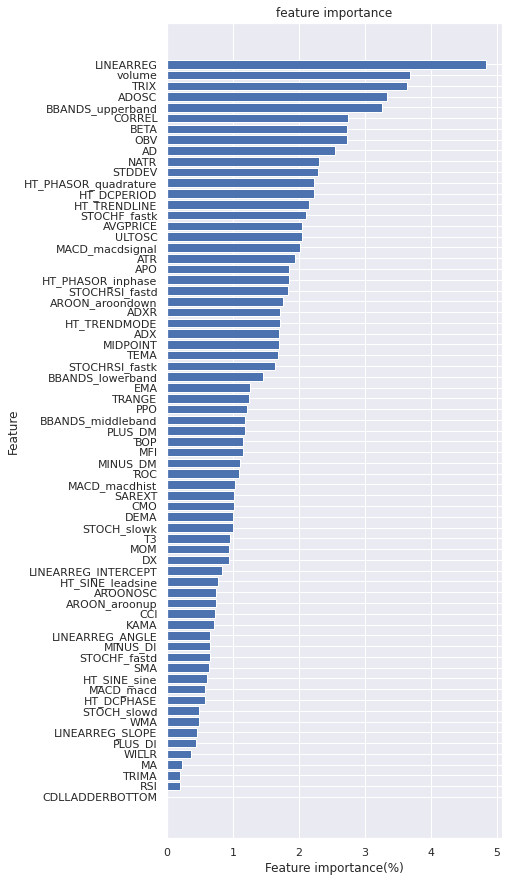

array(['LINEARREG', 'volume', 'TRIX', 'ADOSC', 'BBANDS_upperband',
       'CORREL', 'BETA', 'OBV', 'AD', 'NATR', 'STDDEV',
       'HT_PHASOR_quadrature', 'HT_DCPERIOD', 'HT_TRENDLINE',
       'STOCHF_fastk', 'AVGPRICE', 'ULTOSC', 'MACD_macdsignal', 'ATR',
       'APO', 'HT_PHASOR_inphase', 'STOCHRSI_fastd', 'AROON_aroondown',
       'ADXR', 'HT_TRENDMODE', 'ADX', 'MIDPOINT', 'TEMA',
       'STOCHRSI_fastk'], dtype=object)


In [126]:
np.set_printoptions(threshold=1000)
border = 1.5

#買いにおける特徴量重要度
#特徴量重要度を可視化
importance_buy_reg = importance_groupby(r_buy_reg["importance_df"])
#重要度を降順にソートし､特徴量選択を行う
#importance_buy_reg = r_buy_reg["importance_df"]
#importance_buy_reg = importance_buy_reg.groupby("feature").mean()
#importance_buy_reg = importance_buy_reg.sort_values("importance", ascending=False)
pprint(np.array(importance_buy_reg[importance_buy_reg["importance"]>border]["feature"]))

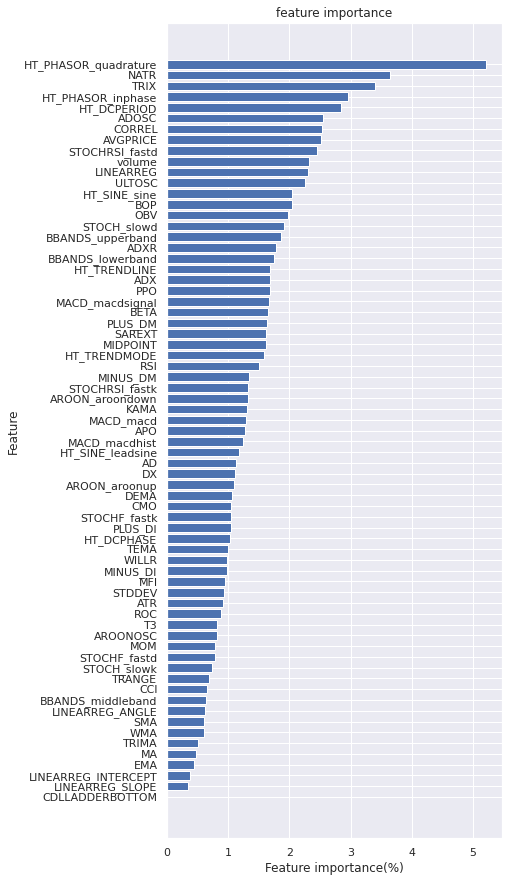

array(['HT_PHASOR_quadrature', 'NATR', 'TRIX', 'HT_PHASOR_inphase',
       'HT_DCPERIOD', 'ADOSC', 'CORREL', 'AVGPRICE', 'STOCHRSI_fastd',
       'volume', 'LINEARREG', 'ULTOSC', 'HT_SINE_sine', 'BOP', 'OBV',
       'STOCH_slowd', 'BBANDS_upperband', 'ADXR', 'BBANDS_lowerband',
       'HT_TRENDLINE', 'ADX', 'PPO', 'MACD_macdsignal', 'BETA', 'PLUS_DM',
       'SAREXT', 'MIDPOINT', 'HT_TRENDMODE'], dtype=object)


In [127]:
#売りにおける特徴量重要度
#特徴量重要度を可視化
importance_sell_reg =  importance_groupby(r_sell_reg["importance_df"])
#重要度を降順にソートし､特徴量選択を行う
#importance_sell_reg = r_sell_reg["importance_df"]
#importance_sell_reg = importance_sell_reg.groupby("feature").mean()
#importance_sell_reg = importance_sell_reg.sort_values("importance", ascending=False)
pprint(np.array(importance_sell_reg[importance_sell_reg["importance"]>border]["feature"]))

y_buy vs y_buy_pred


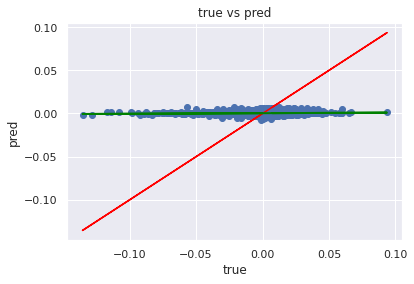

y_sell vs y_sell_pred


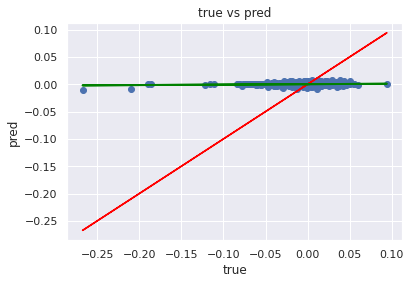

,R2,MSE,RMSE
label,,,
buy_evaluations_validation,0.006013,0.000045,0.006695
sell_evaluations_validation,0.010619,0.000045,0.006706


In [128]:
#モデルの評価
print("y_buy vs y_buy_pred")
evaluations_buy_reg = calculate_scores(train_df_buy["y_buy"], r_buy_reg["y_pred"])
print("y_sell vs y_sell_pred")
evaluations_sell_reg = calculate_scores(train_df_sell["y_sell"], r_sell_reg["y_pred"])

evaluations_buy_reg["label"] = ["buy_evaluations_validation"]
evaluations_sell_reg["label"] = ["sell_evaluations_validation"]

evaluations_df_validation = pd.concat([evaluations_buy_reg, evaluations_sell_reg])
evaluations_df_validation = evaluations_df_validation.set_index(["label"])

from google.colab import data_table
data_table.disable_dataframe_formatter()
evaluations_df_validation

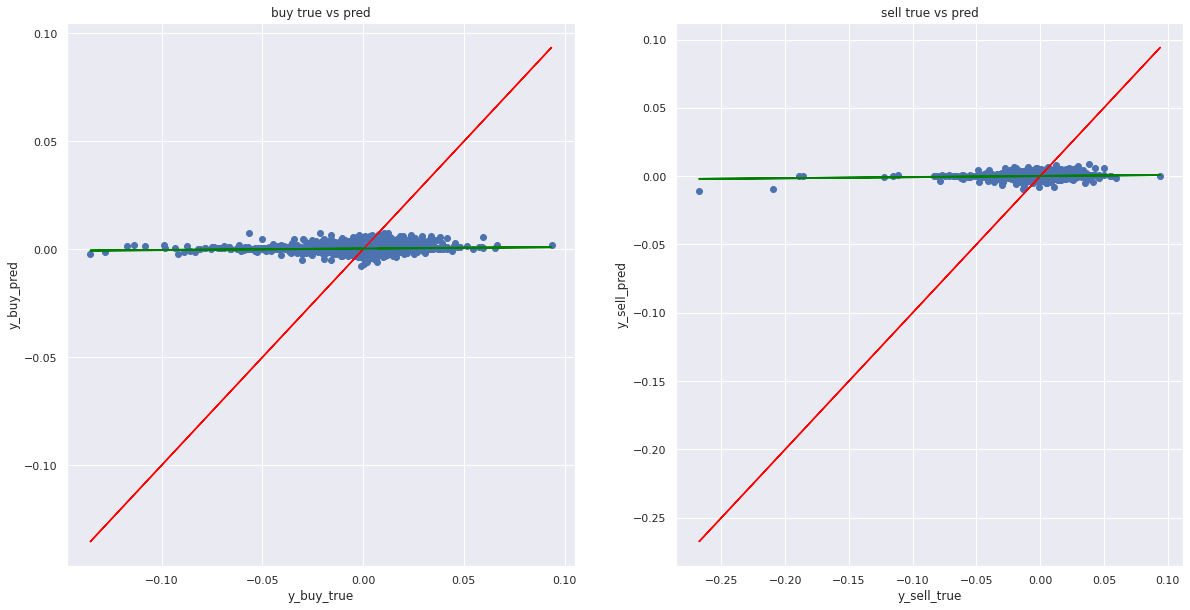

In [129]:
# 回帰分析　線形
mod = LinearRegression()


fig = plt.figure(figsize=(20,10))

ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(train_df_buy["y_buy"], train_df_buy["y_buy"], color = 'red', label = 'x=y') # 直線y = x (真値と予測値が同じ場合は直線状に点がプロットされる)
ax1.scatter(train_df_buy["y_buy"], r_buy_reg["y_pred"]) # 散布図のプロット
ax1.set_xlabel('y_buy_true') # x軸ラベル
ax1.set_ylabel('y_buy_pred') # y軸ラベル
ax1.set_title('buy true vs pred') # グラフタイトル

mod_buy = mod.fit(pd.DataFrame(train_df_buy["y_buy"]), pd.DataFrame(r_buy_reg["y_pred"]))
y_buy_linreg = mod_buy.predict(pd.DataFrame(train_df_buy["y_buy"]))
ax1.plot(train_df_buy["y_buy"], y_buy_linreg, color = '#008000', linewidth=2)

ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(train_df_sell["y_sell"], train_df_sell["y_sell"], color = 'red', label = 'x=y') # 直線y = x (真値と予測値が同じ場合は直線状に点がプロットされる)
ax2.scatter(train_df_sell["y_sell"], r_sell_reg["y_pred"]) # 散布図のプロット
ax2.set_xlabel('y_sell_true') # x軸ラベル
ax2.set_ylabel('y_sell_pred') # y軸ラベル
ax2.set_title('sell true vs pred') # グラフタイトル

mod_sell = mod.fit(pd.DataFrame(train_df_sell["y_sell"]), pd.DataFrame(r_sell_reg["y_pred"]))
y_sell_linreg = mod_sell.predict(pd.DataFrame(train_df_sell["y_sell"]))
ax2.plot(train_df_sell["y_sell"], y_sell_linreg, color = '#008000', linewidth=2)



fig.show()

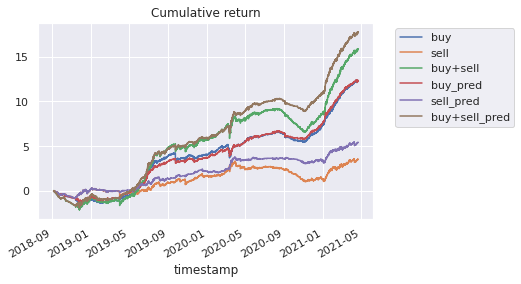

15.899314279988278

In [130]:
#元のDFと､予測値を結合し､y_pred>0のときだけ取引した場合の結果を表示
train_df_buy['y_pred_buy'] = r_buy_reg["y_pred"]
train_df_sell['y_pred_sell'] = r_sell_reg["y_pred"]

train_df['y_pred_buy'] = train_df_buy['y_pred_buy']
train_df['y_pred_sell'] = train_df_sell['y_pred_sell']

train_df = train_df.fillna(0)

train_df['y_buy'].cumsum().plot(label='buy')
train_df['y_sell'].cumsum().plot(label='sell')
(train_df['y_buy'] + train_df['y_sell']).cumsum().plot(label='buy+sell')
plt.title('Cumulative return')
plt.legend(bbox_to_anchor=(1.05, 1))

train_df[train_df['y_pred_buy'] > 0]['y_buy'].cumsum().plot(label='buy_pred')
train_df[train_df['y_pred_sell'] > 0]['y_sell'].cumsum().plot(label='sell_pred')
(train_df['y_buy'] * (train_df['y_pred_buy'] > 0) + train_df['y_sell'] * (train_df['y_pred_sell'] > 0)).cumsum().plot(label='buy+sell_pred')
plt.title('Cumulative return')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

(train_df['y_buy'] + train_df['y_sell']).cumsum().iloc[-1]
#(train_df['y_buy'] * (train_df['y_pred_buy'] > 0) + train_df['y_sell'] * (train_df['y_pred_sell'] > 0)).cumsum().iloc[-1]

***モデルの評価2***  
回帰で予測するが､実際にはリターンがプラスかマイナスかを指標としてトレードを行う｡  
そのため､分類モデルの評価手法を利用して､モデルを評価する

買い 混同行列
[[ 1338 11140]
 [ 2221 19601]]


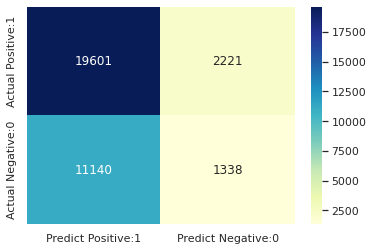

In [131]:
#2値分類したカラムを作成
train_df_buy["y_buy_bin"] = np.where(train_df_buy["y_buy"]>0, 1, 0)
train_df_buy["y_buy_pred_bin"] = np.where(train_df_buy["y_pred_buy"]>0, 1, 0)
print("買い 混同行列")
cm_buy = confusion_matrix(train_df_buy["y_buy_bin"], train_df_buy["y_buy_pred_bin"])
print(cm_buy)
cm_buy = pd.DataFrame(data=cm_buy, columns=['Predict Negative:0', 'Predict Positive:1'], 
                                           index=['Actual Negative:0', 'Actual Positive:1'])
cm_buy = cm_buy.reindex(index=['Actual Positive:1', 'Actual Negative:0'], columns=['Predict Positive:1', 'Predict Negative:0'])
sns.heatmap(cm_buy, annot=True, fmt='d', cmap='YlGnBu')

In [132]:
buy_clf_report = classification_report(train_df_buy["y_buy_bin"], train_df_buy["y_buy_pred_bin"])
print(buy_clf_report)

              precision    recall  f1-score   support

           0       0.38      0.11      0.17     12478
           1       0.64      0.90      0.75     21822

    accuracy                           0.61     34300
   macro avg       0.51      0.50      0.46     34300
weighted avg       0.54      0.61      0.54     34300



売り 混同行列


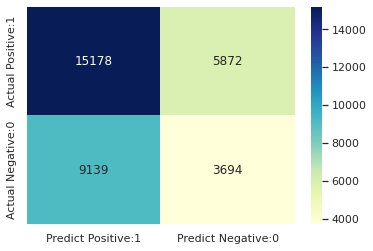

In [133]:
train_df_sell["y_sell_bin"] = np.where(train_df_sell["y_sell"]>0, 1, 0)
train_df_sell["y_sell_pred_bin"] = np.where(train_df_sell["y_pred_sell"]>0, 1, 0)

print("売り 混同行列")
cm_sell = confusion_matrix(train_df_sell["y_sell_bin"], train_df_sell["y_sell_pred_bin"])

cm_sell = pd.DataFrame(data=cm_sell, columns=['Predict Negative:0', 'Predict Positive:1'], 
                                           index=['Actual Negative:0', 'Actual Positive:1'])
cm_sell = cm_sell.reindex(index=['Actual Positive:1', 'Actual Negative:0'], columns=['Predict Positive:1', 'Predict Negative:0'])
sns.heatmap(cm_sell, annot=True, fmt='d', cmap='YlGnBu')

In [134]:
sell_clf_report = classification_report(train_df_sell["y_sell_bin"], train_df_sell["y_sell_pred_bin"])
print(sell_clf_report)

              precision    recall  f1-score   support

           0       0.39      0.29      0.33     12833
           1       0.62      0.72      0.67     21050

    accuracy                           0.56     33883
   macro avg       0.51      0.50      0.50     33883
weighted avg       0.53      0.56      0.54     33883



***テストデータで検証***


In [135]:
df = pd.read_pickle('/content/drive/My Drive/Colab Notebooks/deliverables/df_for_learn.pkl')

In [136]:
#学習用と テスト用 に分割
#一応時系列として､過去から未来を予測する｡
#テストサイズの決定
#一回の学習で3ヶ月利用するとして､データが約3年分(36ヶ月)あるので､1/12
#流石にテストデータが足りなくなりすぎるので､無難に20%をテストデータに
#半時系列データということで､シャッフルはしない
train_df, test_df = train_test_split(df, test_size=test_size, shuffle=False)

In [137]:
#エントリーしたところのみのDF作成(y_buy!=0  y_sell!=0)
train_df_buy = train_df[train_df["y_buy"]!=0]
train_df_sell = train_df[train_df["y_sell"]!=0]

# KFold法 インデックス番号(0,1,2,3,,,,)で出てくるので注意! ilocをつかう
cv_indicies_buy = list(KFold().split(train_df_buy))
cv_indicies_sell = list(KFold().split(train_df_sell))

In [138]:
r_buy_reg = my_cross_val_predict(train_df_buy[buy_features], train_df_buy['y_buy'], cv_indicies_buy, test_df[buy_features], test_df["y_buy"])
r_sell_reg = my_cross_val_predict(train_df_sell[sell_features], train_df_sell['y_sell'], cv_indicies_sell, test_df[sell_features], test_df["y_sell"])

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018415 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16384
[LightGBM] [Info] Number of data points in the train set: 27440, number of used features: 68
[LightGBM] [Info] Start training from score 0.000487
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[11]	valid_0's rmse: 0.00561225
[ 0.0010595   0.0010595   0.0010595  ... -0.00175397  0.0005936
  0.0006085 ]
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019297 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16384
[LightGBM] [Info] Number of data points in the train set: 27440, number of used features: 68
[LightGBM] [Info] Start training from score 0.000283
Training until validation scores don't improve for 100 rounds
Did not meet early stoppin

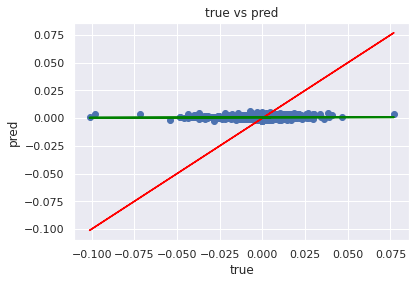

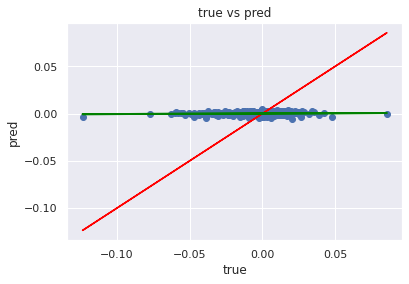

,R2,MSE,RMSE
label,,,
buy_evaluations_validation,0.006013,0.000045,0.006695
sell_evaluations_validation,0.010619,0.000045,0.006706
buy_evaluations_test,-0.028254,0.000019,0.004310
sell_evaluations_test,-0.003328,0.000019,0.004349


In [139]:
test_df["y_pred_buy"] = r_buy_reg["y_test_pred"]
buy_evals = calculate_scores(test_df["y_buy"], test_df["y_pred_buy"])

test_df["y_pred_sell"] = r_sell_reg["y_test_pred"]
sell_evals = calculate_scores(test_df["y_sell"], test_df["y_pred_sell"])

##evaluation 
buy_evals["label"] = np.array(["buy_evaluations_test"])
sell_evals["label"] = np.array(["sell_evaluations_test"])

evaluations_df_test = pd.concat([buy_evals, sell_evals])
evaluations_df_test = evaluations_df_test.set_index(["label"])

evaluations_df_comparison = pd.concat([evaluations_df_validation, evaluations_df_test])
evaluations_df_comparison

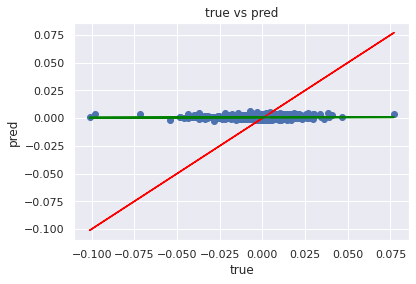

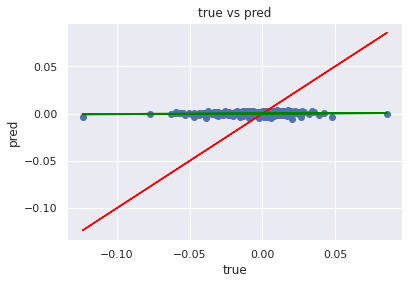

,R2,MSE,RMSE
label,,,
buy_evaluations_validation,0.006013,0.000045,0.006695
sell_evaluations_validation,0.010619,0.000045,0.006706
buy_evaluations_test,-0.005400,0.000047,0.006863
sell_evaluations_test,0.005639,0.000049,0.006982


In [140]:
test_df["y_pred_buy"] = r_buy_reg["y_test_pred"]
test_df_buy = test_df[test_df["y_buy"]!=0]
buy_evals = calculate_scores(test_df_buy["y_buy"], test_df_buy["y_pred_buy"])

test_df["y_pred_sell"] = r_sell_reg["y_test_pred"]
test_df_sell = test_df[test_df["y_sell"]!=0]
sell_evals = calculate_scores(test_df_sell["y_sell"], test_df_sell["y_pred_sell"])

##evaluation 
buy_evals["label"] = np.array(["buy_evaluations_test"])
sell_evals["label"] = np.array(["sell_evaluations_test"])

evaluations_df_test = pd.concat([buy_evals, sell_evals])
evaluations_df_test = evaluations_df_test.set_index(["label"])

evaluations_df_comparison = pd.concat([evaluations_df_validation, evaluations_df_test])
evaluations_df_comparison

毎時刻、y_predがプラスのときだけトレードした場合の累積リターン 比較


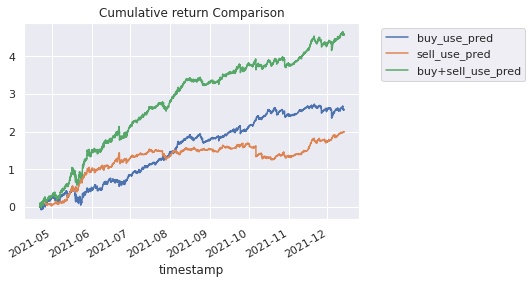

In [141]:
print('毎時刻、y_predがプラスのときだけトレードした場合の累積リターン 比較')
#test_df['y_buy'].cumsum().plot(label='buy')
#test_df['y_sell'].cumsum().plot(label='sell')
#(test_df['y_buy'] + test_df['y_sell']).cumsum().plot(label='buy+sell')

test_df[test_df['y_pred_buy'] > 0]['y_buy'].cumsum().plot(label='buy_use_pred')
test_df[test_df['y_pred_sell'] > 0]['y_sell'].cumsum().plot(label='sell_use_pred')
(test_df['y_buy'] * (test_df['y_pred_buy'] > 0) + test_df['y_sell'] * (test_df['y_pred_sell'] > 0)).cumsum().plot(label='buy+sell_use_pred')

plt.title('Cumulative return Comparison')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()


***2値分類の評価指標を適用***

買い 混同行列
[[ 224 2971]
 [ 417 5065]]


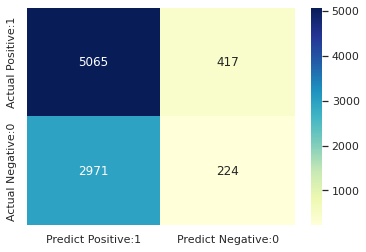

In [142]:
#2値分類したカラムを作成
test_df_buy = test_df[test_df["y_buy"]!=0]
test_df_buy["y_buy_bin"] = np.where(test_df_buy["y_buy"]>0, 1, 0)
test_df_buy["y_buy_pred_bin"] = np.where(test_df_buy["y_pred_buy"]>0, 1, 0)
print("買い 混同行列")
cm_buy = confusion_matrix(test_df_buy["y_buy_bin"], test_df_buy["y_buy_pred_bin"])
print(cm_buy)
cm_buy = pd.DataFrame(data=cm_buy, columns=['Predict Negative:0', 'Predict Positive:1'], 
                                           index=['Actual Negative:0', 'Actual Positive:1'])
cm_buy = cm_buy.reindex(index=['Actual Positive:1', 'Actual Negative:0'], columns=['Predict Positive:1', 'Predict Negative:0'])
sns.heatmap(cm_buy, annot=True, fmt='d', cmap='YlGnBu')

In [143]:
buy_clf_report = classification_report(test_df_buy["y_buy_bin"], test_df_buy["y_buy_pred_bin"], output_dict=True)
buy_clf_report = pd.DataFrame(buy_clf_report)
buy_clf_report

,0,1,accuracy,macro avg,weighted avg
precision,0.349454,0.630289,0.609542,0.489871,0.526881
recall,0.070110,0.923933,0.609542,0.497021,0.609542
f1-score,0.116788,0.749371,0.609542,0.433080,0.516445
support,3195.000000,5482.000000,0.609542,8677.000000,8677.000000


売り 混同行列


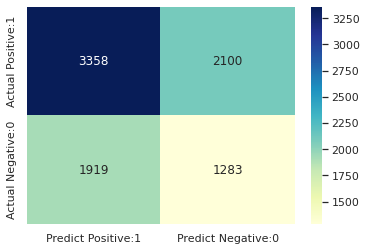

In [144]:
test_df_sell = test_df[test_df["y_sell"]!=0]
test_df_sell["y_sell_bin"] = np.where(test_df_sell["y_sell"]>0, 1, 0)
test_df_sell["y_sell_pred_bin"] = np.where(test_df_sell["y_pred_sell"]>0, 1, 0)

print("売り 混同行列")
cm_sell = confusion_matrix(test_df_sell["y_sell_bin"], test_df_sell["y_sell_pred_bin"])

cm_sell = pd.DataFrame(data=cm_sell, columns=['Predict Negative:0', 'Predict Positive:1'], 
                                           index=['Actual Negative:0', 'Actual Positive:1'])
cm_sell = cm_sell.reindex(index=['Actual Positive:1', 'Actual Negative:0'], columns=['Predict Positive:1', 'Predict Negative:0'])
sns.heatmap(cm_sell, annot=True, fmt='d', cmap='YlGnBu')

In [145]:
sell_clf_report = classification_report(test_df_sell["y_sell_bin"], test_df_sell["y_sell_pred_bin"], output_dict=True)
sell_clf_report = pd.DataFrame(sell_clf_report)
sell_clf_report

,0,1,accuracy,macro avg,weighted avg
precision,0.379249,0.636346,0.535912,0.507798,0.541286
recall,0.400687,0.615244,0.535912,0.507965,0.535912
f1-score,0.389674,0.625617,0.535912,0.507645,0.538378
support,3202.000000,5458.000000,0.535912,8660.000000,8660.000000
